# Lab 05: Wine Quality

---
author: Qiran Hu
date: October 11, 2024
embed-resources: true
---

## Introduction

In this report, we aim develop a predictive model to predict wine quality based on its characteristics. Evaluating the quality of wine traditionally relies on the expertise of sommeliers who are professionals specializing in wine services and wine food tasting. However, the nuanced flavors and aromas that distinguish one wine from another can be challenging for the average consumer to discern. Instead of only relying on human experts, we propose to utilize advanced machine learning models to analyze these data obtained through specialized chemistry equipment. By training our model on historical wine quality reviews that are provided by professional sommeliers, we hope to create an AI Sommelier that is capable of predicting wine quality which makes it more accessible and engaging for a diverse audience ranging from casual wine drinkers to enthusiasts to enjoy the best quality wine. While our model significantly enhances the ability to predict wine quality based on measurable attributes, it is specialized in predicting wine quality which does not capture other personal preferences and food pairings.

## Methods

In [1]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

### Data

In [2]:
# load data
wine_train = pd.read_csv(
    "https://cs307.org/lab-05/data/wine-train.csv",
)
wine_test = pd.read_csv(
    "https://cs307.org/lab-05/data/wine-test.csv",
)

In [3]:
wine_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.6,0.23,0.64,12.9,0.033,54.0,170.0,0.99800,3.00,0.53,8.8,5,white
1,NaN,0.75,0.01,2.2,0.059,11.0,18.0,0.99242,3.39,0.40,NaN,6,red
2,7.4,0.67,0.12,1.6,0.186,5.0,21.0,0.99600,3.39,0.54,9.5,5,red
3,6.4,0.18,0.74,NaN,0.046,54.0,168.0,0.99780,3.58,0.68,10.1,5,white
4,6.7,0.35,0.32,9.0,0.032,29.0,113.0,0.99188,3.13,0.65,12.9,7,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4152,6.6,0.32,0.22,16.7,0.046,38.0,133.0,0.99790,3.22,0.67,10.4,6,white
4153,9.2,0.58,0.20,3.0,0.081,15.0,115.0,0.99800,3.23,0.59,9.5,5,red
4154,8.2,0.60,0.17,2.3,0.072,11.0,73.0,0.99630,3.20,0.45,9.3,5,red
4155,6.5,0.23,0.36,16.3,0.038,43.0,133.0,0.99924,3.26,0.41,8.8,5,white


### Data Dictionary
To achieve the goal of this research, we will collect wine quality data from the wine-train.csv as train data and 
wine-test.csv as the test data. The original source of the data is based on the article Modeling wine preferences by data mining from physicochemical properties Decision support systems. However, the data from this paper has become a standard dataset in the machine learning community, and thus is made available via the UC Irvine Machine Learning Repository. The original data contains two separate datasets, one for red wine and one for white wine. Here, we have combined the data and added a column for the color of the wine. We have made additional modifications to the original data.

Each observation in the train, test, and production data contains information about a particular Portuguese “Vinho Verde” wine which is a unique product from the Minho region of Portugal.

#### Response variable:

**`quality`** - `[int64]` the quality of the wine based on evaluation by a minimum of three sensory assessors (using blind tastes), which graded the wine in a scale that ranges from 0 (very bad) to 10 (excellent)

#### Features variables:

**`color`** - `[object]` the (human perceivable) color of the wine, red or white

**`fixed acidity`** - `[float64]` grams of tartaric acid per cubic decimeter

**`volatile acidity`** - `[float64]` grams of acetic acid per cubic decimeter

**`citric acid`** - `[float64]` grams of citric acid per cubic decimeter

**`residual sugar`** - `[float64]` grams of residual sugar per cubic decimeter

**`chlorides`** - `[float64]` grams of sodium chloride cubic decimeter

**`free sulfur dioxide`** - `[float64]` milligrams of free sulfur dioxide per cubic decimeter

**`total sulfur dioxide`** - `[float64]` milligrams of total sulfur dioxide per cubic decimeter

**`density`** - `[float64]` the total density of the wine in grams per cubic centimeter

**`pH`** - `[float64]` the acidity of the wine measured using pH

**`sulphates`** - `[float64]` grams of potassium sulphate cubic decimeter

**`alcohol`** - `[float64]` percent alcohol by volume

In [4]:
# summary statistics
wine_train.shape[0]

4157

In [5]:
wine_train.shape[1]

13

In [6]:
wine_train.isna().any()

fixed acidity            True
volatile acidity        False
citric acid              True
residual sugar           True
chlorides               False
free sulfur dioxide      True
total sulfur dioxide    False
density                 False
pH                       True
sulphates                True
alcohol                  True
quality                 False
color                   False
dtype: bool

In [7]:
Numeric_Features = wine_train.select_dtypes(include=["int64", "float64"])
Numeric_Features.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,3987.000000,4157.000000,3958.000000,3917.000000,4157.000000,4133.000000,4157.000000,4157.000000,3921.000000,3934.000000,3961.000000,4157.000000
mean,7.220579,0.342403,0.316478,5.430406,0.056358,30.600048,115.221915,0.994710,3.218454,0.531784,10.502847,5.814289
std,1.295282,0.166465,0.145276,4.750618,0.035460,17.906396,56.581139,0.003004,0.159184,0.150914,1.189918,0.868748
min,3.800000,0.080000,0.000000,0.600000,0.012000,1.000000,6.000000,0.987110,2.740000,0.230000,8.000000,3.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,17.000000,77.000000,0.992380,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.300000,0.310000,3.000000,0.048000,29.000000,118.000000,0.994900,3.210000,0.505000,10.300000,6.000000
75%,7.700000,0.410000,0.390000,8.100000,0.066000,41.000000,155.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.330000,1.230000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


This training dataset has a sample size of 4157 instances and 12 unique feature variables, which is large enough to split into train and test data sets. In addition, the large amount of sample size ensures that the predicted results are less likely to be biased. Based on the dataset, it presents a variety of important features related to wine characteristics and quality. The standard deviation in feature variables like residual sugar with 4.75 standard deviation and total sulfur dioxide with 56.58 standard deviation which are considerably high compared to other variables like pH with 0.16 standard deviation and alcohol with 1.19 standard deviation. This suggests that some features may be relatively consistent across wines while others like sugar content and sulfur dioxide levels can vary significantly which indicate that these features are key factors in distinguishing different types or qualities of wine. In addition, he wide range for residual sugar with a minimum of 0.6 and maximum of 65.8 and chlorides with minimum of 0.012 and maximum of 0.611 demonstrate potential outliers in the data. Wines with extremely high sugar content or chloride levels might either be outliers or represent a distinct category. However, there are some missing values in columns like "fixed acidity," "residual sugar," and "alcohol," which may require additional process to ensure a complete analysis. The "quality" ratings usually range from 3 to 9; it provides a general view about how does high quality wine look like compared to low quality wine. Since the dataset also includes both "white" and "red" wines, our predictive model could also analyze how wine color could relates to quality. As one can see, understanding the relationships between these variables and the quality ratings can offer valuable insights into what makes a wine more favorable.

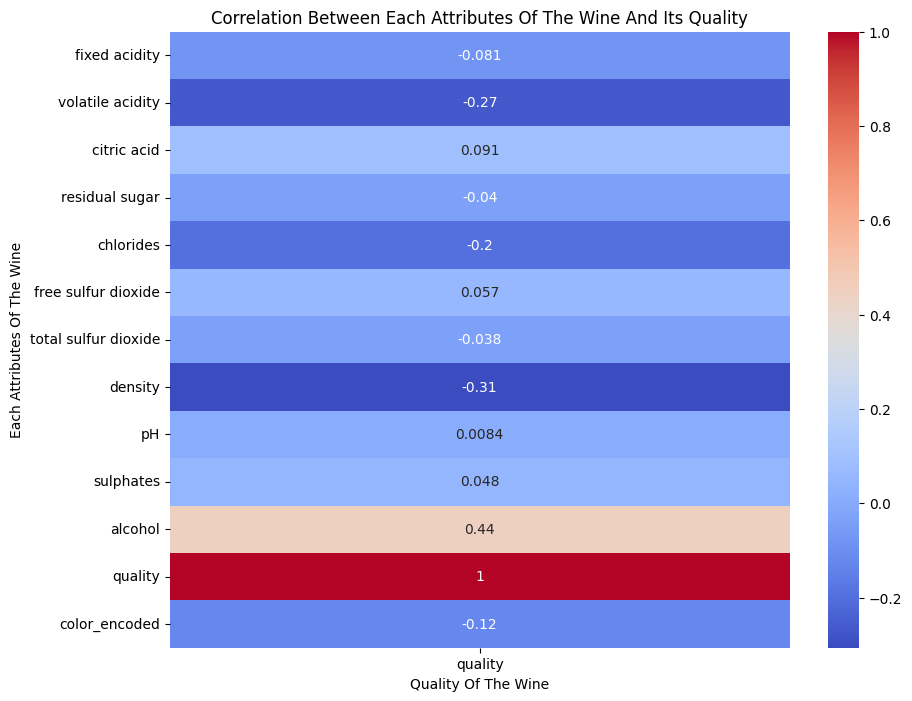

In [8]:
#visualization 
wine_train_df = wine_train.copy()
wine_train_df['color_encoded'] = wine_train_df['color'].map({'white': 0, 'red': 1})
wine_train_df_with_color = wine_train_df.drop(columns=['color'])
correlation_with_color = wine_train_df_with_color.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_with_color[['quality']], annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Between Each Attributes Of The Wine And Its Quality')
plt.xlabel('Quality Of The Wine')
plt.ylabel('Each Attributes Of The Wine')
plt.show()

The heatmap visualization of the correlation between various wine attributes and quality provides significant insights into how different variables influence the overall quality rating of wines. This heatmap focuses on the relationship between each feature and wine quality in order to provide a clear and straightforward representation of these correlations. For instance, the alcohol content shows a strong positive correlation with quality which indicates that wines with higher alcohol content tend to be rated more favorably. In contrast, density displays the strongest negative correlation which demonstrates that higher density wines may be associated with lower quality ratings. Other variables such as fixed acidity and chlorides also illustrate negative correlations with quality while residual sugar and sulphates have weak positive relationships. One thing that we found interesting is that the encoded wine color where red is represented as 1 and white as 0 has a moderately negative correlation with quality. The weak negative relationship of -0.12 shows that red wines tend to receive slightly lower ratings than white wines in this dataset. As one can see, this heatmap offers a comprehensive overview of how individual factors contribute to wine quality which provides valuable insights for winemakers and consumers to understand how high quality wine looks like. Furthermore, these information also help winemakers in refining wine production processes or guiding consumer preferences based on these characteristics.

### Models

In [9]:
# create X and y for train
X_train = wine_train.drop("quality", axis=1)
y_train = wine_train["quality"]

# create X and y for test
X_test = wine_test.drop("quality", axis=1)
y_test = wine_test["quality"]

In [10]:
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns

In [11]:
# process data for ML
numeric_preprocessor = Pipeline(
    steps=[
        ("MedianImputer", SimpleImputer(strategy="median")),
        ("Standardize", StandardScaler()),
    ]
)
categorical_preprocessor = Pipeline(
    steps=[
        ("ModalImputer", SimpleImputer(strategy="most_frequent")),
        ("OneHotEncoder", OneHotEncoder(handle_unknown="infrequent_if_exist", max_categories=5)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("CategoricalPreprocessing", categorical_preprocessor, categorical_features),
        ("NumericProcessing", numeric_preprocessor, numeric_features),
    ]
)
pipeline = Pipeline(
    steps=[
        ("Preprocessor", preprocessor),
        ("regressor", KNeighborsRegressor()),
    ]
)

In [12]:
param_grid = {
    "regressor__n_neighbors": range(1, 100),
    "regressor__metric": ["euclidean", "manhattan"],
    "regressor__weights": ["uniform", "distance"]
}

In [13]:
mod = GridSearchCV(pipeline, param_grid, cv = 5, scoring='neg_mean_absolute_error')

In [14]:
mod.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocessor',
                                        ColumnTransformer(transformers=[('CategoricalPreprocessing',
                                                                         Pipeline(steps=[('ModalImputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('OneHotEncoder',
                                                                                          OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                        max_categories=5))]),
                                                                         Index(['color'], dtype='object')),
                                                                        ('NumericProcessing',
                                                                         Pipeline(steps...
                                                                         Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object'))])),
                                       ('regressor', KNeighborsRegressor())]),
             param_grid={'regressor__metric': ['euclidean', 'manhattan'],
                         'regressor__n_neighbors': range(1, 100),
                         'regressor__weights': ['uniform', 'distance']},
             scoring='neg_mean_absolute_error')

In [15]:
mod.best_params_

{'regressor__metric': 'manhattan',
 'regressor__n_neighbors': 6,
 'regressor__weights': 'distance'}

In order to develop an effective model to predict a wine's quality based on its physicochemical characteristics, we implemented a k nearest neighbors regressor in our predictive model. Since our primary objective was to identify the model that provides the highest accuracy in predicting wine quality scores in the creation of an AI Sommelier, we began by processing the dataset by separating the target variable quality from the feature set for both training and testing datasets. The features variables were categorized into numeric and categorical types in order to apply appropriate preprocessing steps. Numeric features utilized median imputation to handle missing values and were then standardized using StandardScaler. Categorical features were imputed using the most frequent value and encoded using one hot encoding with infrequent categories being appropriately managed. To optimize the model's performance, we constructed a pipeline that integrated the preprocessing steps with a KNeighborsRegressor. We conducted an extensive grid search over a range of hyperparameters in order to tune the model. For instance, we varied the number of neighbors from 1 to 99 to find the optimal neighborhood size. We also experimented with different distance metrics between euclidean and manhattan to measure the similarity between data points and we adjusted the weighting scheme between uniform and distance to see which provided better predictions. The model was evaluated using 5 fold cross validation with the negative mean absolute error as the scoring metric to accurately predict a wine's quality based on its physicochemical attributes.

## Results

In [16]:
# report model metrics
y_test_pred = mod.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
print(f"Test MAE: {test_mae}")

Test MAE: 0.46258472193212025


In [17]:
from joblib import dump
dump(mod, "wine-quality.joblib")

['wine-quality.joblib']

After training and validation, the grid search identified the optimal hyperparameters of 6 keighbors with distance metric of manhattan and weights of distance. By utilizing the KNeighborsRegressor with these optimized parameters, our model effectively predicts wine quality based on measurable physicochemical attributes which significantly enhances the ability to assess wine quality and aligns with our goal to create an AI Sommelier. As a result, we trained the final k nearest neighbors regressor model by using these optimized parameters. We then evaluated its performance on the test dataset and obtain a test mean absolute error of 0.46258472193212025. Since the low test mean absolute error indicates that the K Nearest Neighbors regressor with the optimized hyperparameters outperforms other models we considered for this task. Its ability to minimize the MAE on the test dataset indicates superior performance in predicting wine quality based on measurable attributes. Thus, this model effectively supports our goal of developing an AI Sommelier by providing accurate and objective assessments of wine quality. 

## Discussion

After extensive hyperparameter tuning and evaluation, we selected the k nearest neighbor regressor model over other models as our final model. The k nearest neighbor classifier with the manhattan and distance metric and k neighbor of 6 obtains an outstanding performance of 0.46258472193212025 on the test dataset for test mean absolute error, which effectively increases the predictive power of our model to predict a wine’s quality given it’s characteristics.

Based on our predictive model, the decision to invest in chemistry equipment and processes to automate wine quality assessment is necessary and worthy in this case. Some people may argue that AI model cannot fully replace the nuanced expertise of a human sommelier because sommeliers have solid foundations and sensory experiences to wine evaluation since the ability to detect subtle aromas, flavors, and textures that are difficult to quantify through chemical analysis alone. They also consider contextual factors such as regional characteristics, vintage variations, and ideal food pairings to provide personalized recommendations that enhance the overall dining experience. For customers seeking a personalized experience or for establishments that pride themselves on exceptional service, the sommeliers remains irreplaceable on account of the fact that AI model lacks the subjective judgment and personal touch that sommeliers offer. However, the AI model excels in providing objective and data driven assessments based on measurable physicochemical properties because it can easily identify patterns and correlations that may not be immediately apparent to humans. Despite the fact that high precision chemistry equipment can be expensive to purchase and maintain which require significant fund to purchase and ongoing operational expenses, this investment could be justified for large scale wine producers or distributors through the increasing efficiency and consistency in quality assessments that an AI model provides. Automating the process can lead to faster evaluations of wine batches which reduce various bottlenecks in production and potentially leading to cost savings over time.Therefore, the AI model can serve as an useful tool to enhance the sommelier's capabilities by providing additional data points for consideration.

Since the quality data provided are integers on a scale from 1 to 10, our regression model predicts continuous numerical values which means that the predictions are not limited to integers and can include decimal values, such as 6.7 or 7.3. This approach is appropriate because it captures the continuous nature of wine quality as perceived through its physicochemical properties. Predicting continuous values is not inherently problematic because it can offer a more comprehensive assessment of wine quality. The decimal predictions can indicate wines that are on the cusp between two integer ratings by providing more detailed information than a strict categorical classification; these continuous predictions can also be rounded to the nearest integer in order to match with traditional rating scales used in the industry.

We chose to use regression instead of classification since wine quality ratings are ordinal and continuous integers. Hence, regression models are better suited for predicting outcomes compared to classification models that assign inputs to discrete categories without accounting for the degree of difference between them, which could lead to a loss of valuable information in this context. On the other hand, if industry standards or consumer expectations favor integer ratings, presenting fractional scores might require additional explanation or adjustment; it is essential to ensure that the output of the model aligns with how the ratings will be used in practice where post processing steps can be helpful to convert continuous predictions into categorical ratings without significantly compromising the model's insights.

As one can see, the AI model offers significant benefits in objectively assessing wine quality based on physicochemical characteristics. By using regression to predict continuous values as outputs, it provides a more detailed and accurate assessment of wine quality. This approach aligns with the continuous nature of the quality variable and leverages the strengths of regression models in capturing subtle variations in data. Futhermore, the integration of AI model into wine evaluation should be seen as a complementary tool to enhances current wine rating techniques rather than replacing human experts. Through the combination of the objective assessments of the AI model with the subjective insights of professional sommeliers, the industry can offer both efficiency and a personalized experience to consumers. 

### Conclusion

As a result, the K Nearest Neighbors regression model we trained demonstrates an outstanding result of a test mean absolute error of 0.46258472193212025 which indicates that the predicted wine quality scores are less than half a point away from the actual ratings assigned by professional sommeliers on average. Given that wine quality ratings are typically integers on a scale from 1 to 10, this level of precision is promising which suggests that the model effectively captures the complex relationships between the measurable attributes of wine and its perceived quality. 

However, it is important to acknowledge the limitations of the model because it cannot replicate the sensory evaluations, contextual knowledge, and personalized recommendations that human sommeliers provide even though it excels in analyzing both train and test data sets. Wine attributes such as aroma complexity, flavor nuances, mouthfeel, and pairing suggestions are beyond the scope of physicochemical analysis alone. On the other hand, considering the given scenario, the investment in chemistry equipment and processes to generate the necessary physicochemical data appears to be justified by the model's performance because ability to predict wine quality with a high degree of accuracy can offer significant advantages in terms of consistency, efficiency, and scalability. For large wineries or distributors who handle vast quantities of wine, this AI model can streamline quality control processes, reduce reliance on the availability of trained sommeliers for every batch, and potentially lower operational costs in the long term.Therefore, we would suggest to implement this AI model in real world scenario on account its high accuracy in predicting wine quality, which makes it a valuable tool for initial assessments and quality assurance. 

The AI Sommelier can serve as an effective supplement to human expertise in order to provide rapid and objective evaluations that can inform decision making in production, distribution, and even marketing strategies. As one can see, the model's outstanding performance with a test mean absolute error of 0.46258472193212025 shows that it is sufficient to use it practical applications within the wine industry. The benefits of integrating this AI system include improved efficiency, consistency, and the ability to handle large volumes of wine assessments. By combining the strengths of both AI and human expertise, wineries can achieve a more comprehensive and effective approach to quality evaluation, ultimately enhancing the consumer experience and maintaining high standards within the industry.